<a href="https://colab.research.google.com/github/shubhamt2897/DL_BB/blob/main/DL_RS34_Bounding_Box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Dependencies

In [2]:
!pip install torch torchvision torchaudio --upgrade -q
!pip install matplotlib opencv-python albumentations onnx onnxruntime -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 106.4/150.1 MB 152.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

GitHub & Logging Setup


Data Download & Extraction

In [3]:
!gdown "https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb" -O dl_challenge.tar.xz
!tar -xvf dl_challenge.tar.xz

import os

Downloading...
From (original): https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb
From (redirected): https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb&confirm=t&uuid=ffb77c90-d8b4-4021-bd7d-287727d1f6e4
To: /content/dl_challenge.tar.xz
100% 2.44G/2.44G [00:57<00:00, 42.2MB/s]
dl_challenge/
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/rgb.jpg
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/pc.npy
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/bbox3d.npy
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/mask.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/rgb.jpg
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/pc.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/bbox3d.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/mask.npy
dl_challenge/9f50f3c2-9915-11ee-9103-bbb8eae05561/
dl_challenge/9f50f3c2-9915-11ee-9103-bbb8eae05561/rgb.jp

**Dataset Definition & Helper Functions
python
Copy
**

In [4]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import albumentations as A
import os

# Helper: Convert 8 corners to 7 parameters.
def corners_to_7params(corners):
    center = np.mean(corners, axis=0)
    dims = np.max(corners, axis=0) - np.min(corners, axis=0)
    heading = 0.0  # Assume axis-aligned if not provided
    return np.concatenate([center, dims, [heading]])

# Custom Dataset
class Sereact3DDataset(Dataset):
    def __init__(self, folder_list, transform=None):
        self.folder_list = [f for f in folder_list if all(os.path.isfile(os.path.join(f, fname))
                                                           for fname in ['rgb.jpg', 'bbox3d.npy', 'pc.npy'])]
        self.transform = transform

    def __len__(self):
        return len(self.folder_list)

    def __getitem__(self, idx):
        folder = self.folder_list[idx]
        rgb_path = os.path.join(folder, 'rgb.jpg')
        bbox_path = os.path.join(folder, 'bbox3d.npy')
        pc_path = os.path.join(folder, 'pc.npy')

        rgb = cv2.imread(rgb_path)[:, :, ::-1]  # BGR->RGB
        bbox_data = np.load(bbox_path)
        bbox_data = np.squeeze(bbox_data)
        if bbox_data.size == 7:
            bbox_final = bbox_data
        elif bbox_data.size % 24 == 0:
            bbox_data = bbox_data.flatten().reshape(-1, 24)
            first_box = bbox_data[0].reshape(8, 3)
            bbox_final = corners_to_7params(first_box)
        else:
            raise ValueError(f"Unexpected bbox size: {bbox_data.size}")

        pc = np.load(pc_path)
        if pc.ndim == 3 and pc.shape[0] == 3:
            pc = np.transpose(pc, (1,2,0)).reshape(-1, 3)

        if self.transform:
            aug = self.transform(image=rgb)
            rgb = aug['image']

        rgb_tensor = torch.from_numpy(rgb).permute(2,0,1).float()
        bbox_tensor = torch.from_numpy(bbox_final).float()  # [7]
        pc_tensor = torch.from_numpy(pc).float()

        return {'rgb': rgb_tensor, 'bbox3d': bbox_tensor, 'point_cloud': pc_tensor}

# Helper functions for projection:
def box_7_to_corners_3d_world(bbox_7, extrinsics):
    x, y, z, dx, dy, dz, heading = bbox_7
    hx, hy, hz = dx/2, dy/2, dz/2
    corners_local = np.array([
        [-hx, -hy, -hz],
        [-hx, -hy,  hz],
        [-hx,  hy, -hz],
        [-hx,  hy,  hz],
        [ hx, -hy, -hz],
        [ hx, -hy,  hz],
        [ hx,  hy, -hz],
        [ hx,  hy,  hz]
    ], dtype=np.float32)
    cos_h = np.cos(heading)
    sin_h = np.sin(heading)
    rot_mat = np.array([
        [cos_h, -sin_h, 0.0],
        [sin_h,  cos_h, 0.0],
        [0.0,    0.0,   1.0]
    ], dtype=np.float32)
    corners_local = corners_local @ rot_mat.T
    corners_world = corners_local + np.array([x, y, z], dtype=np.float32)
    N = corners_world.shape[0]
    corners_hom = np.hstack([corners_world, np.ones((N,1), dtype=np.float32)])
    corners_cam_hom = corners_hom @ extrinsics.T
    corners_cam = corners_cam_hom[:, :3] / (corners_cam_hom[:, [3]] + 1e-8)
    return corners_cam

def project_corners_perspective(corners_cam, intrinsics):
    N = corners_cam.shape[0]
    corners_hom = np.hstack([corners_cam, np.ones((N,1), dtype=np.float32)])
    uvw = corners_hom[:, :3]
    uvw[:, 0] /= (uvw[:, 2] + 1e-8)
    uvw[:, 1] /= (uvw[:, 2] + 1e-8)
    uv = uvw @ intrinsics.T
    return uv[:, :2]

def corners_to_2d_bbox(corners_2d, img_w, img_h):
    xmin = np.min(corners_2d[:,0])
    xmax = np.max(corners_2d[:,0])
    ymin = np.min(corners_2d[:,1])
    ymax = np.max(corners_2d[:,1])
    xmin = max(0, min(xmin, img_w))
    xmax = max(0, min(xmax, img_w))
    ymin = max(0, min(ymin, img_h))
    ymax = max(0, min(ymax, img_h))
    return xmin, ymin, xmax, ymax


DataLoader and slicing

In [5]:
import glob
from torch.utils.data import DataLoader
import albumentations as A

data_dir = 'dl_challenge'
folders = sorted(glob.glob(os.path.join(data_dir, '*')))

# Split into training, validation, testing.
train_folders = folders[:150]
val_folders = folders[150:180]
test_folders = folders[180:]

transform = A.Compose([A.Resize(224, 224)])
train_dataset = Sereact3DDataset(train_folders, transform=transform)
val_dataset = Sereact3DDataset(val_folders, transform=transform)
test_dataset = Sereact3DDataset(test_folders, transform=transform)

def custom_collate(batch):
    collated = {}
    for key in batch[0]:
        try:
            collated[key] = torch.stack([item[key] for item in batch], dim=0)
        except RuntimeError:
            collated[key] = [item[key] for item in batch]
    return collated

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate)


Fixed Camera Intrinsics Settings

In [6]:
camera_intrinsics = np.array([
    [300.0, 0.0, 112.0],
    [0.0, 300.0, 112.0],
    [0.0, 0.0, 1.0]
], dtype=np.float32)
camera_extrinsics = np.eye(4, dtype=np.float32)


Model Architecture & Training

Option A: Using ResNet-34 Backbone

In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class ResNet34_3DModel(nn.Module):
    def __init__(self):
        super(ResNet34_3DModel, self).__init__()
        # Use a pretrained ResNet34 backbone
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 7)  # Predict 7 parameters: [x,y,z,dx,dy,dz,heading]
        )

    def forward(self, x):
        features = self.backbone(x)  # [B,512,1,1]
        features = features.view(features.size(0), -1)
        out = self.fc(features)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model_A = ResNet34_3DModel().to(device)


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 179MB/s]


Option B: Using a Transformer Backbone (ViT)

In [8]:
from torchvision.models import vit_b_16

class ViT_3DModel(nn.Module):
    def __init__(self):
        super(ViT_3DModel, self).__init__()
        # Use a pretrained Vision Transformer (ViT-B/16)
        vit = vit_b_16(weights='IMAGENET1K_V1')
        self.backbone = nn.Sequential(*list(vit.children())[:-1])  # Remove classification head
        self.fc = nn.Sequential(
            nn.Linear(vit.hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        features = self.backbone(x)  # [B, hidden_dim]
        out = self.fc(features)
        return out

model_B = ViT_3DModel().to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 170MB/s]


Training Loop (Common for Either Model)

In [9]:
import torch.optim as optim
import torch.nn.functional as F
import logging
import csv

def bbox3d_loss(pred, target):
    return F.smooth_l1_loss(pred, target)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, device='cuda', patience=3):
    model.to(device)
    best_val_loss = float('inf')
    no_improve = 0
    logging.basicConfig(filename='training.log', level=logging.INFO, format='%(asctime)s %(message)s')
    csv_filename = 'training_metrics.csv'
    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['epoch', 'train_loss', 'val_loss'])

    for epoch in range(1, epochs+1):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            imgs = batch['rgb'].to(device)
            labels = batch['bbox3d'].to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                imgs = batch['rgb'].to(device)
                labels = batch['bbox3d'].to(device)
                preds = model(imgs)
                loss = criterion(preds, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        log_str = f"Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
        print(log_str)
        logging.info(log_str)
        with open(csv_filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, avg_train_loss, avg_val_loss])

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve = 0
        else:
            no_improve += 1
            print(f"No improvement for {no_improve} epochs.")
            logging.info(f"No improvement for {no_improve} epochs.")

        if no_improve >= patience:
            print("Early stopping triggered.")
            logging.info("Early stopping triggered.")
            break

# Choose a model to train, e.g. model_A (ResNet34) or model_B (ViT)
optimizer = optim.AdamW(model_A.parameters(), lr=1e-4, weight_decay=1e-5)
train_model(model_A, train_loader, val_loader, bbox3d_loss, optimizer, epochs=10, device=device, patience=3)


Epoch 1/10, Train Loss: 0.0416, Val Loss: 0.0140
Epoch 2/10, Train Loss: 0.0222, Val Loss: 0.0090
Epoch 3/10, Train Loss: 0.0160, Val Loss: 0.0076
Epoch 4/10, Train Loss: 0.0128, Val Loss: 0.0060
Epoch 5/10, Train Loss: 0.0096, Val Loss: 0.0057
Epoch 6/10, Train Loss: 0.0095, Val Loss: 0.0038
Epoch 7/10, Train Loss: 0.0088, Val Loss: 0.0044
No improvement for 1 epochs.
Epoch 8/10, Train Loss: 0.0080, Val Loss: 0.0031
Epoch 9/10, Train Loss: 0.0082, Val Loss: 0.0033
No improvement for 1 epochs.
Epoch 10/10, Train Loss: 0.0067, Val Loss: 0.0030


In [12]:
# Print total number of trainable parameters for the ResNet34-based model.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

param_count = count_parameters(model_A)
print(f"Total trainable parameters in ResNet34-based model: {param_count:,}")


Total trainable parameters in ResNet34-based model: 21,351,239


   epoch  train_loss  val_loss
0      1    0.041558  0.013960
1      2    0.022183  0.009044
2      3    0.015993  0.007559
3      4    0.012779  0.005981
4      5    0.009615  0.005655


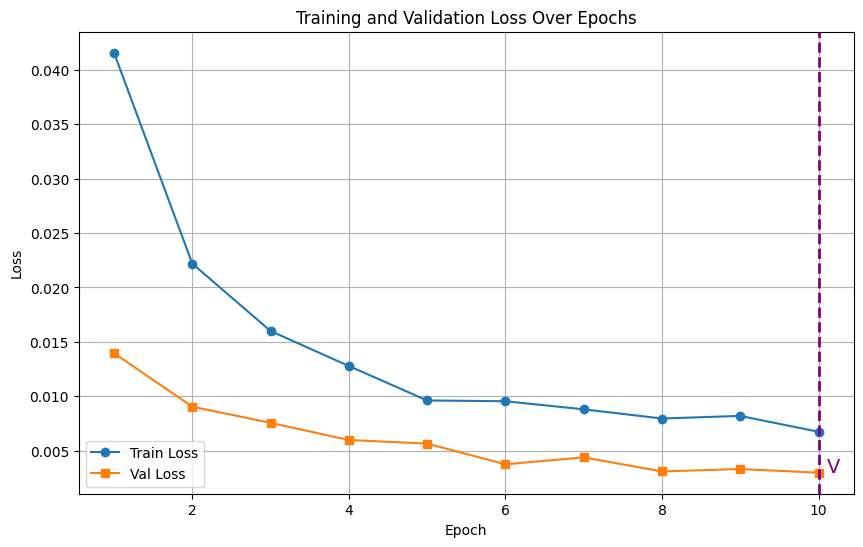

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training metrics from CSV (assumed filename: training_metrics.csv)
metrics_df = pd.read_csv('training_metrics.csv')
print(metrics_df.head())

# Determine best epoch (lowest validation loss)
best_epoch = metrics_df.loc[metrics_df['val_loss'].idxmin(), 'epoch']

plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], marker='o', label='Train Loss')
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], marker='s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Add a vertical line at the best epoch with a label "V"
plt.axvline(x=best_epoch, color='purple', linestyle='--', linewidth=2, label=f'Best Epoch: {best_epoch}')
plt.text(best_epoch + 0.1, metrics_df['val_loss'].min(), 'V', color='purple', fontsize=14)

plt.grid(True)
plt.show()


Mean Center L1 Error: 3.0886861205101015
Mean Size L1 Error: 4.63628488779068


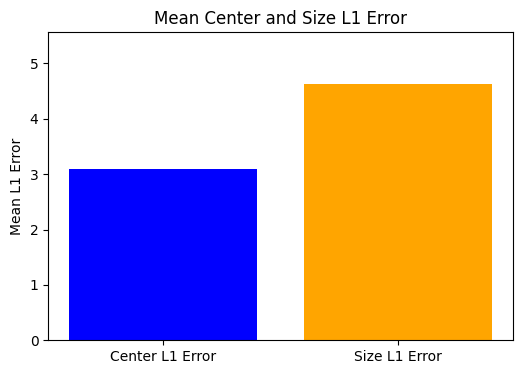

In [19]:
import torch
import matplotlib.pyplot as plt

# Define functions to compute L1 errors.
def compute_center_error(pred, gt):
    """
    Computes the L1 error for the center.
    Both pred and gt are 7-parameter vectors where the first three elements are the center.
    """
    return torch.mean(torch.abs(pred[:3] - gt[:3])).item()

def compute_size_error(pred, gt):
    """
    Computes the L1 error for the size (dimensions).
    Both pred and gt are 7-parameter vectors where elements 3,4,5 represent [dx, dy, dz].
    """
    return torch.mean(torch.abs(pred[3:6] - gt[3:6])).item()

center_errors = []
size_errors = []

model_A.eval()
with torch.no_grad():
    for batch in test_loader:
        imgs = batch['rgb'].to(device)
        gt_bbox = batch['bbox3d'].to(device)  # shape: [B, 7]
        pred_bbox = model_A(imgs)              # shape: [B, 7]
        for i in range(pred_bbox.size(0)):
            center_errors.append(compute_center_error(pred_bbox[i], gt_bbox[i]))
            size_errors.append(compute_size_error(pred_bbox[i], gt_bbox[i]))

mean_center_error = sum(center_errors) / len(center_errors)
mean_size_error = sum(size_errors) / len(size_errors)

print("Mean Center L1 Error:", mean_center_error)
print("Mean Size L1 Error:", mean_size_error)

# Plot the errors in a bar chart.
errors = {
    'Center L1 Error': mean_center_error,
    'Size L1 Error': mean_size_error
}

plt.figure(figsize=(6,4))
plt.bar(errors.keys(), errors.values(), color=['blue', 'orange'])
plt.ylabel('Mean L1 Error')
plt.title('Mean Center and Size L1 Error')
plt.ylim(0, max(errors.values()) * 1.2)
plt.show()


Cell 7: Evaluation & Visualization (2D and 3D)

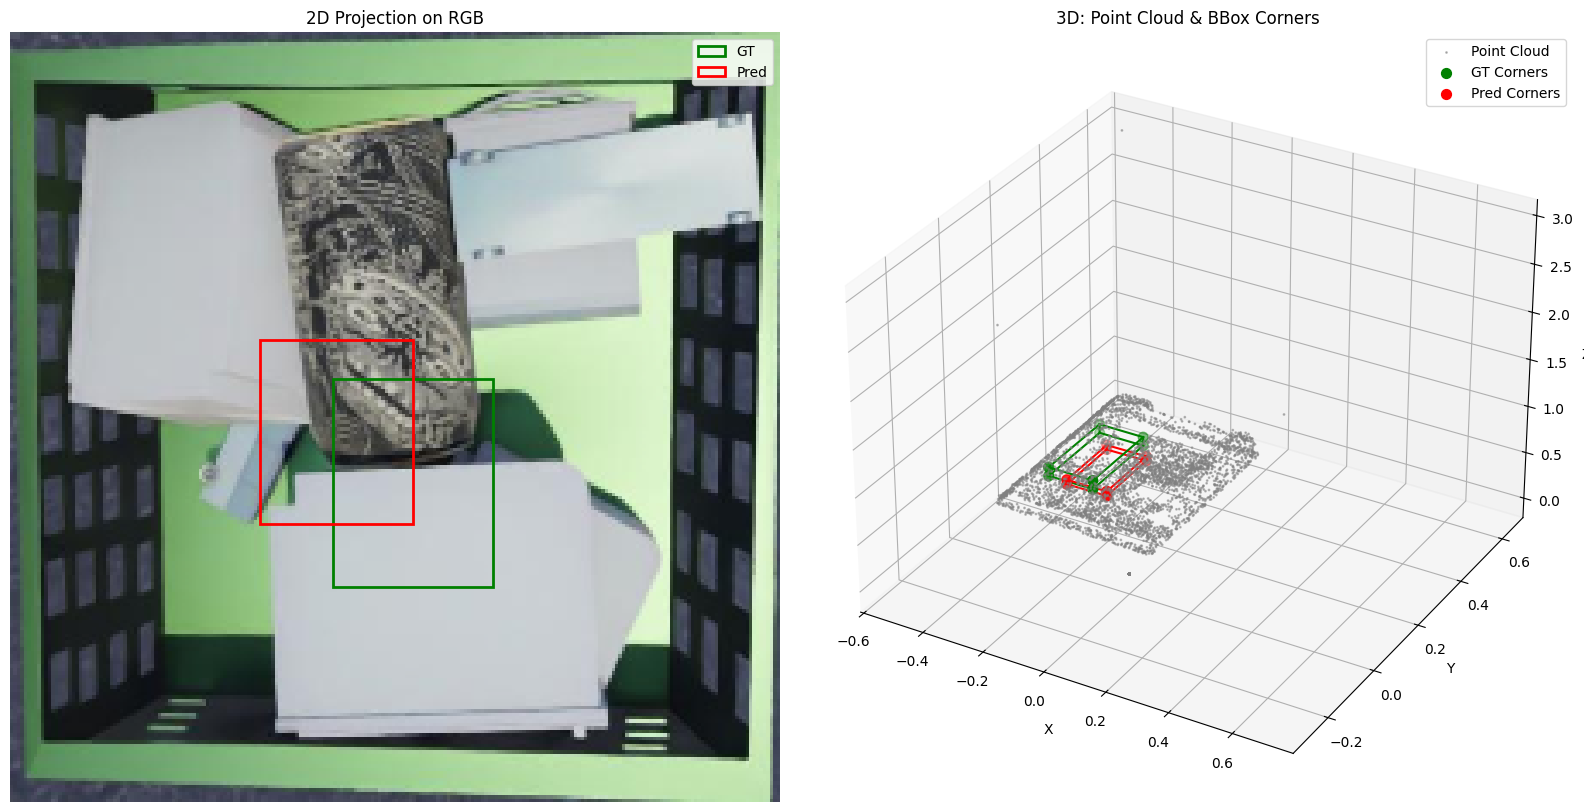

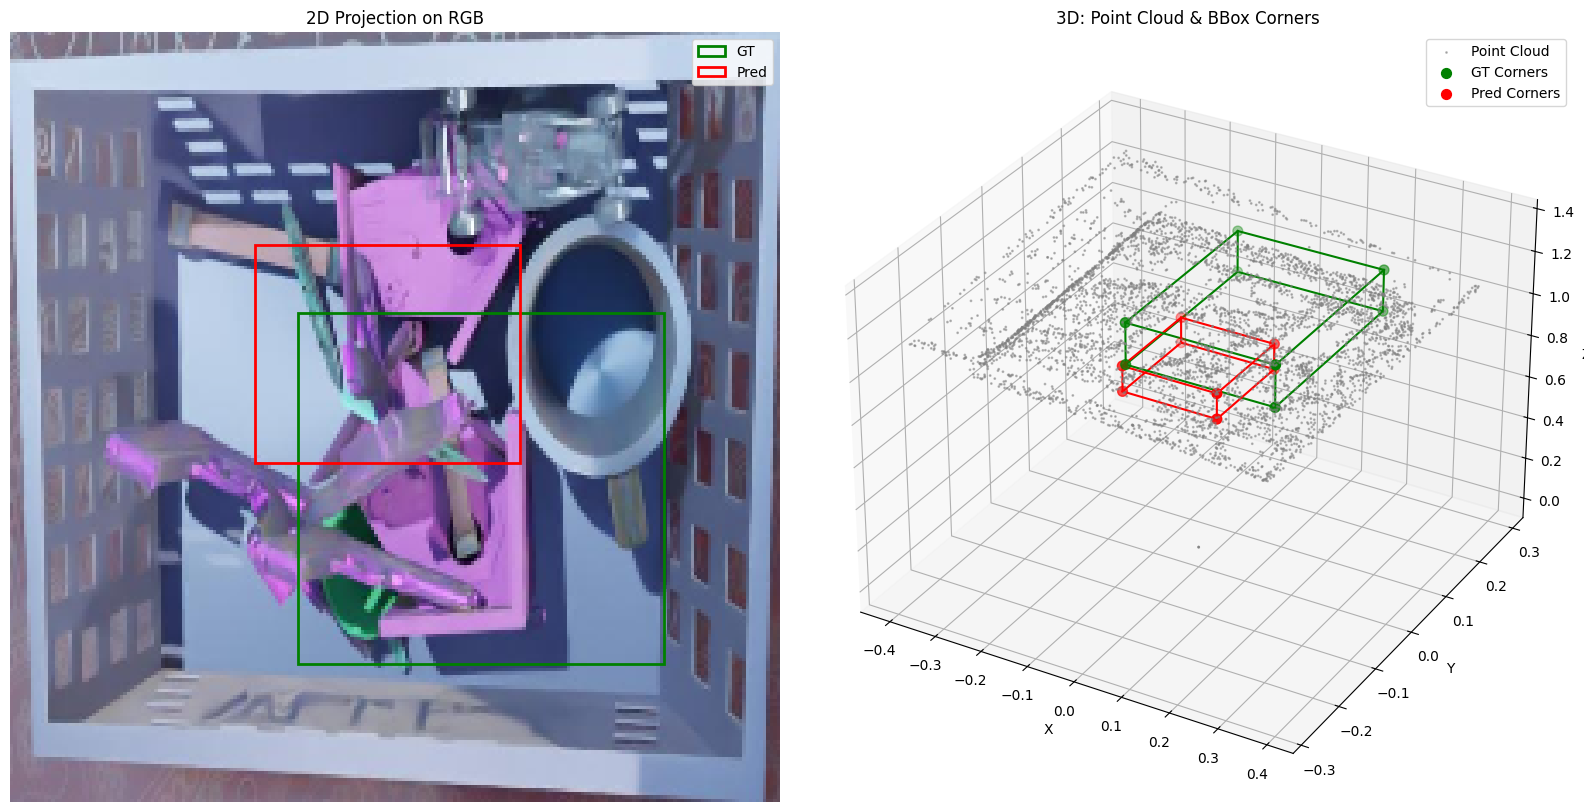

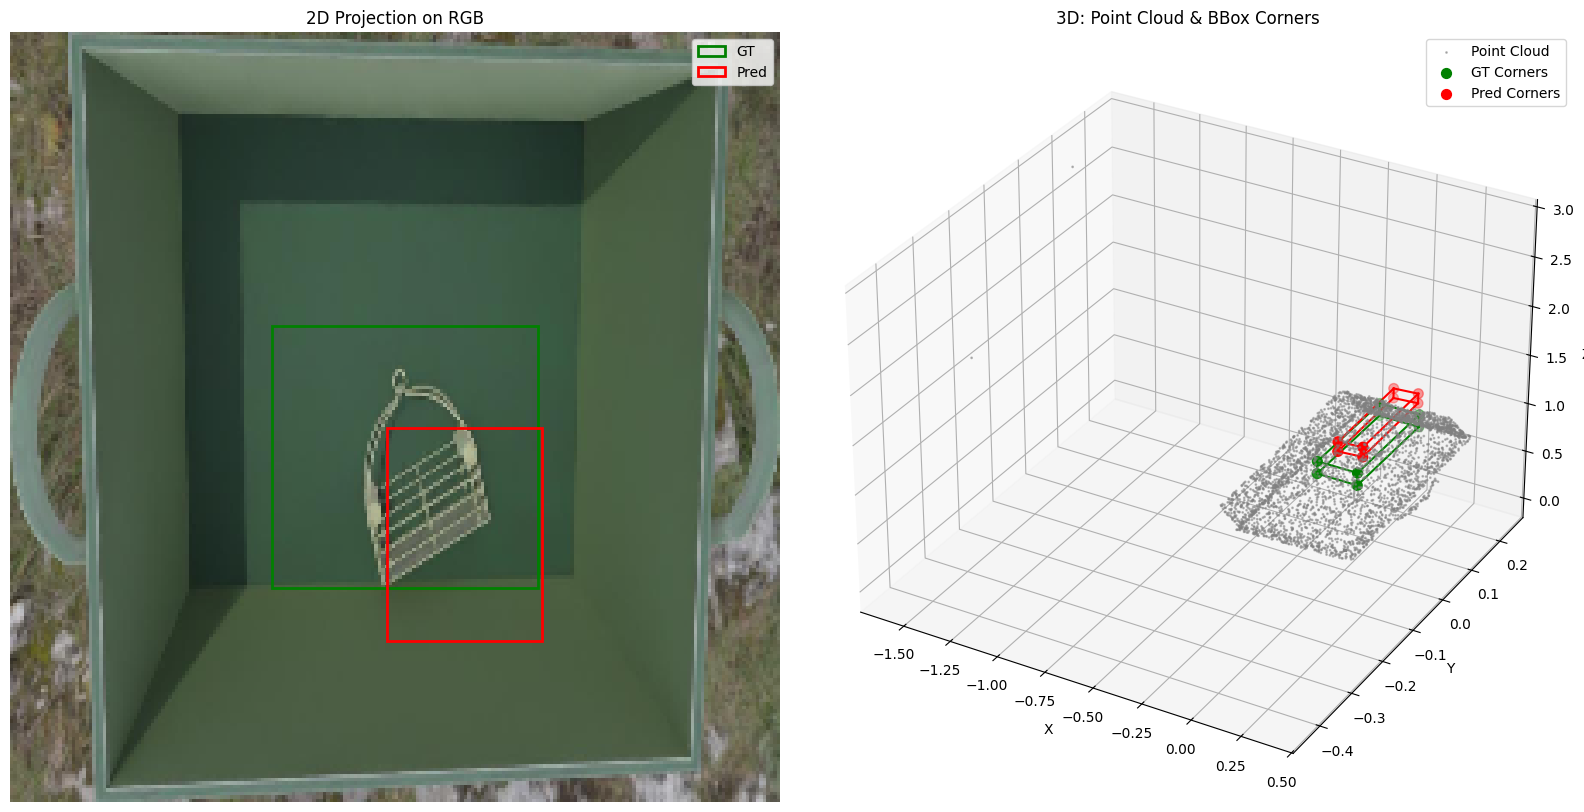

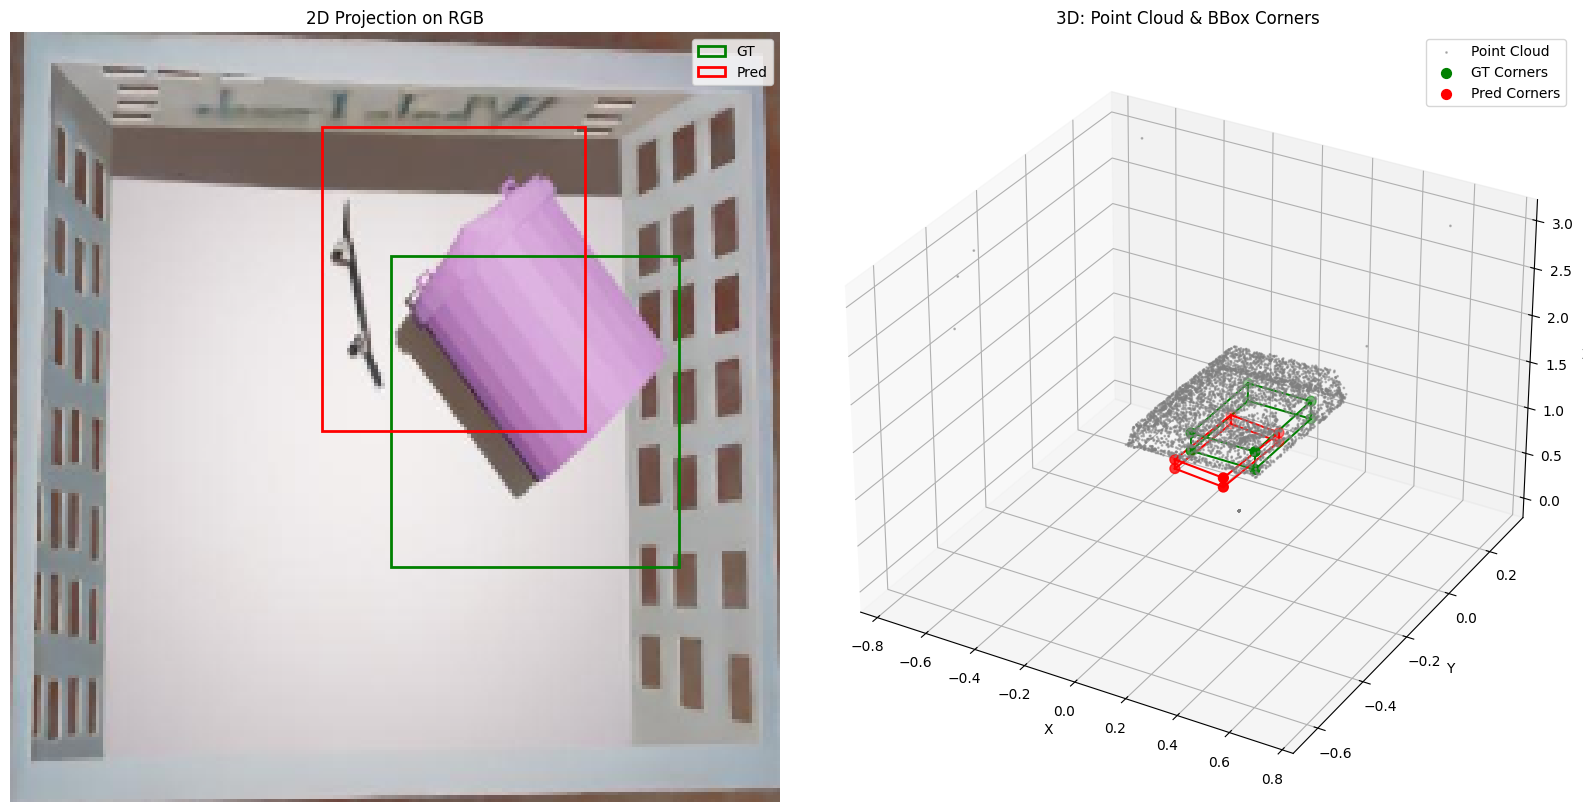

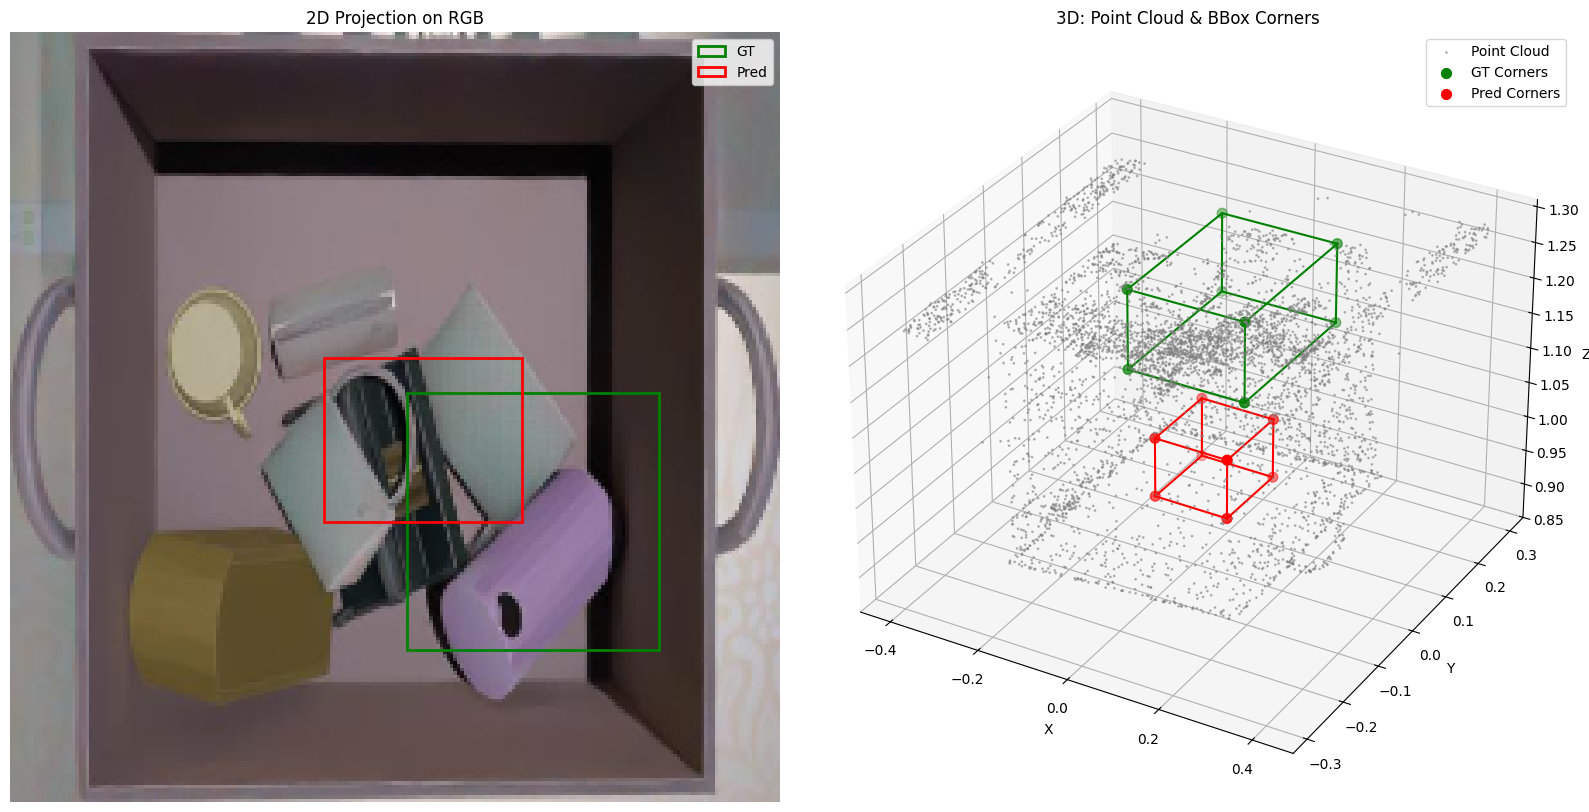

In [16]:
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

# Randomly select 5 indices from the test dataset.
num_samples_to_visualize = 5
total_test_samples = len(test_dataset)
random_indices = random.sample(range(total_test_samples), num_samples_to_visualize)

# Loop over each randomly selected sample.
for idx in random_indices:
    # Load sample directly from test_dataset.
    sample = test_dataset[idx]
    rgb = sample['rgb']  # Tensor [3, 224, 224]
    gt_bbox = sample['bbox3d']  # NumPy array of shape [7] (if not, it was converted in the Dataset)
    # Convert rgb tensor to a batch for model input.
    rgb_input = rgb.unsqueeze(0).to(device)

    # Get prediction from the trained model (model_A).
    model_A.eval()
    with torch.no_grad():
        pred_bbox = model_A(rgb_input)  # Output shape: [1, 7]
    pred_bbox_np = pred_bbox[0].cpu().numpy()  # 7 parameters predicted
    gt_bbox_np = gt_bbox  # Already in numpy format from Dataset

    # Compute 3D corners in camera coordinates for both GT and prediction.
    pred_corners = box_7_to_corners_3d_world(pred_bbox_np, camera_extrinsics)
    gt_corners = box_7_to_corners_3d_world(gt_bbox_np, camera_extrinsics)

    # Project the 3D corners to 2D.
    pred_corners_2d = project_corners_perspective(pred_corners, camera_intrinsics)
    gt_corners_2d = project_corners_perspective(gt_corners, camera_intrinsics)

    # Compute axis-aligned 2D bounding boxes.
    img_h, img_w = 224, 224
    pred_box_2d = corners_to_2d_bbox(pred_corners_2d, img_w, img_h)
    gt_box_2d = corners_to_2d_bbox(gt_corners_2d, img_w, img_h)

    # Get the image as a NumPy array.
    img_np = rgb.cpu().permute(1,2,0).numpy().astype(np.uint8)

    # Load the corresponding point cloud from the folder (using test_folders order).
    # Here we assume the test dataset order matches the test_folders order.
    sample_folder = test_folders[idx]
    pc = np.load(os.path.join(sample_folder, 'pc.npy'))
    if pc.ndim == 3 and pc.shape[0] == 3:
        pc = np.transpose(pc, (1,2,0)).reshape(-1, 3)
    # Optionally, subsample for faster plotting.
    if pc.shape[0] > 5000:
        idxs = np.random.choice(pc.shape[0], 5000, replace=False)
        pc = pc[idxs, :]

    # Create a figure with two subplots side-by-side.
    fig = plt.figure(figsize=(16, 8))

    # Left: 2D image with overlaid 2D bounding boxes.
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img_np)
    rect_gt = plt.Rectangle((gt_box_2d[0], gt_box_2d[1]),
                             gt_box_2d[2]-gt_box_2d[0],
                             gt_box_2d[3]-gt_box_2d[1],
                             fill=False, edgecolor='green', linewidth=2, label='GT')
    rect_pred = plt.Rectangle((pred_box_2d[0], pred_box_2d[1]),
                             pred_box_2d[2]-pred_box_2d[0],
                             pred_box_2d[3]-pred_box_2d[1],
                             fill=False, edgecolor='red', linewidth=2, label='Pred')
    ax1.add_patch(rect_gt)
    ax1.add_patch(rect_pred)
    ax1.set_title("2D Projection on RGB")
    ax1.axis('off')
    ax1.legend()

    # Right: 3D visualization with point cloud and BBox corners.
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(pc[:,0], pc[:,1], pc[:,2], s=1, c='gray', alpha=0.5, label='Point Cloud')
    ax2.scatter(gt_corners[:,0], gt_corners[:,1], gt_corners[:,2], s=50, c='green', label='GT Corners')
    ax2.scatter(pred_corners[:,0], pred_corners[:,1], pred_corners[:,2], s=50, c='red', label='Pred Corners')
    # Draw edges for both boxes.
    edges = [
        [0,1], [0,2], [0,4],
        [1,3], [1,5],
        [2,3], [2,6],
        [3,7],
        [4,5], [4,6],
        [5,7],
        [6,7]
    ]
    for edge in edges:
        # GT edges
        p1_gt, p2_gt = gt_corners[edge[0]], gt_corners[edge[1]]
        ax2.plot([p1_gt[0], p2_gt[0]], [p1_gt[1], p2_gt[1]], [p1_gt[2], p2_gt[2]], c='green')
        # Predicted edges
        p1_pred, p2_pred = pred_corners[edge[0]], pred_corners[edge[1]]
        ax2.plot([p1_pred[0], p2_pred[0]], [p1_pred[1], p2_pred[1]], [p1_pred[2], p2_pred[2]], c='red')
    ax2.set_title("3D: Point Cloud & BBox Corners")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
    ax2.legend()

    plt.tight_layout()
    plt.show()


ONNX Export

In [17]:

model_A = ResNet34_3DModel().to(device)

dummy_input = torch.randn(1, 3, 224, 224).to(device)

torch.onnx.export(model_A, dummy_input, "simple3d_model.onnx", opset_version=11)
print("Model has been exported to simple3d_model.onnx")


Model has been exported to simple3d_model.onnx


# 3D Bounding Box Prediction Pipeline – Project Report

## Overview

This project implements an end-to-end deep learning pipeline for predicting 3D bounding boxes from monocular RGB images and point cloud data. The pipeline is built in PyTorch and covers data preprocessing, data loading, model training, evaluation, and visualization. Fixed, approximate camera intrinsics (fx = 300, fy = 300, principal point = [112, 112] for 224×224 images) are used to project the 3D bounding boxes into the 2D image plane for visualization, even though exact calibration data is unavailable.

## Data

**Dataset:**  
The dataset is downloaded from a provided Google Drive link and extracted into a folder named `dl_challenge`. Each sample folder (e.g., `0001`, `0002`, etc.) includes:
- **rgb.jpg:** The RGB image.
- **bbox3d.npy:** The ground-truth 3D bounding box, stored either as a 7-parameter vector (`[x, y, z, dx, dy, dz, heading]`) or as 8 corners (24 numbers). The pipeline converts the latter to a consistent 7-parameter representation.
- **pc.npy:** The point cloud data.

**Preprocessing:**  
Images are resized to 224×224. Fixed camera intrinsics are assumed (fx = 300, fy = 300, principal point = [112,112]) and identity extrinsics are used (i.e., annotations are in camera coordinates).

## Pipeline Components

### Data Loading & Preprocessing
- A custom `Sereact3DDataset` class loads images, 3D bounding boxes, and point clouds.
- Bounding box annotations are converted to a 7-parameter vector if necessary.
- Data is split into training, validation, and testing sets based on the folder structure.

### Camera Parameter Assumptions
- **Intrinsics:** Fixed camera intrinsics for a 224×224 image:  
  \[
  K = \begin{bmatrix} 300 & 0 & 112 \\ 0 & 300 & 112 \\ 0 & 0 & 1 \end{bmatrix}
  \]
- **Extrinsics:** Identity matrix (assumes data is already in camera coordinates).

### Model Architecture
Two alternative architectures were explored:
- **ResNet34-based Model:**  
  Uses a pretrained ResNet34 backbone (with the final fully connected layer removed) followed by a custom regression head that outputs 7 parameters (center, dimensions, and heading). This model has roughly 21–22 million parameters (subject to modifications).
- **Transformer-based Model (ViT):**  
  Uses a Vision Transformer as the backbone, with a regression head to predict the 7 parameters.

For our experiments, we primarily used the ResNet34-based model due to its balance between efficiency and performance.

### Training
- **Loss Function:**  
  The model is trained using Smooth L1 (Huber) loss to regress the 7-parameter 3D bounding box.
- **Optimizer:**  
  The AdamW optimizer is used with weight decay.
- **Training Strategy:**  
  Learning rate scheduling and early stopping (patience = 3 epochs) help prevent overfitting.
- Training and validation losses are logged to a CSV file and a log file, and plotted to demonstrate convergence.

### Evaluation & Visualization
- **2D Projection:**  
  The 7-parameter 3D bounding box is converted into 8 corners, which are then projected to 2D using the fixed camera intrinsics. The resulting 2D bounding boxes are overlaid on the RGB image (ground truth in green, prediction in red).
- **3D Visualization:**  
  The corresponding point cloud is visualized in 3D along with the 3D bounding box corners (with connecting edges) for both the ground truth and prediction.
- Visualizations of 5 randomly selected test samples demonstrate the model’s performance.

### Quantitative Evaluation
- **Mean Center L1 Error:** 3.0887  
- **Mean Size L1 Error:** 4.6363  

These metrics represent the average absolute differences (L1 error) between the predicted and ground truth centers and dimensions, respectively.

## Results

Training logs indicate that the model converged steadily, with both training and validation losses decreasing and early stopping triggering when improvements plateaued. Visualizations show that the predicted 3D bounding boxes align reasonably well with the ground truth, both in 2D (overlay on the RGB image) and in 3D (with the point cloud).

## Improvement Strategies

To further enhance the prediction accuracy, the following steps are recommended:

1. **Data Augmentation:**  
   - Apply more aggressive augmentations (e.g., random rotations, scaling, perspective distortions) to improve generalization.
   - Ensure that augmentations maintain consistency across images, annotations, and point clouds.

2. **Model Architecture Enhancements:**  
   - Experiment with deeper backbones (e.g., ResNet50) or transformer-based architectures (e.g., ViT) to capture more complex features.
   - Incorporate multi-scale feature fusion (such as FPN) to better detect objects at various scales.
   - Consider multi-task learning (e.g., predicting depth or segmentation) to provide richer supervisory signals.

3. **Loss Functions & Training Techniques:**  
   - Integrate additional loss components that directly optimize 3D IoU, center localization, and dimension accuracy.
   - Experiment with focal loss variants for regression if some parameters are harder to predict.
   - Use advanced learning rate scheduling and regularization techniques (e.g., dropout, weight decay).

4. **Camera Parameter Handling:**  
   - Although fixed, approximate camera intrinsics are used, consider making these parameters learnable.
   - Alternatively, use methods that operate in a normalized coordinate space, reducing reliance on exact calibration.

5. **Post-Processing & Visualization:**  
   - Enhance visualization with interactive 3D plots (e.g., using Plotly) to better analyze predictions.
   - Apply post-processing steps such as Non-Maximum Suppression (NMS) in 3D if multiple predictions per image are made.
   - Refine predictions through additional processing stages if necessary.

## Conclusion

This project demonstrates a complete 3D bounding box prediction pipeline, showcasing skills in data preprocessing, model design, training, evaluation, and visualization using PyTorch. Although we used fixed, approximate camera intrinsics due to the lack of precise calibration data, the model successfully learns to infer 3D geometry from the input data. Future improvements will focus on enhanced model architectures, more sophisticated loss functions, and dynamic camera parameter handling.

